In [1]:
import numpy as np
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
METHOD = 'cnn_self-training'

LABELLED_DATA_FILE = 'data/all_label.p'
UNLABELED_DATA_FILE = 'data/all_unlabel.p'
TEST_DATA_FILE = 'data/test.p'

OUTPUT_FOLDER = 'output/'
MODEL_FOLDER = 'model/' + METHOD + '/'

In [3]:
import os
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Train

### Loading Training Data

In [4]:
labelled_data = np.array(pickle.load(open(LABELLED_DATA_FILE, 'rb')))
unlabeled_data = np.array(pickle.load(open(UNLABELED_DATA_FILE, 'rb')))

In [12]:
nb_classes = 10
img_rows, img_cols, img_channels = 32, 32, 3

In [6]:
# generate x, y from data

# reshape labelled data to (5000, 3, 32, 32)
X_train_label = labelled_data.reshape((5000, img_channels, img_rows, img_cols)).astype('float32') / 255

# reshape unlabeled data to (45000, 3, 32, 32)
nb_unlabeled_data = unlabeled_data.shape[0]
X_train_unlabel = unlabeled_data.reshape((nb_unlabeled_data, img_channels, img_rows, img_cols)).astype('float32') / 255

y_train_label_class = np.array([classIdx for classIdx in range(len(labelled_data)) for i in range(len(labelled_data[classIdx]))])
Y_train_label = np_utils.to_categorical(y_train_label_class, nb_classes)

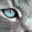

In [7]:
# visualize
from scipy.misc import toimage
toimage(X_train_unlabel[5])

### Training

In [8]:
batch_size = 32
nb_epoch = 100

# nb_filters = [32, 64]
# nb_nodes = [512]

In [9]:
# set model

model = Sequential()

model.add(Convolution2D(64, 5, 5, border_mode='same', input_shape=X_train_label.shape[1:]))
model.add(Activation('relu'))
# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
# model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
# model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))  # 32 * 
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# let's train the model using SGD + momentum (how original).
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
# train first model

model.fit(X_train_label, Y_train_label,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
#           validation_set=(X_train_label, Y_train_label),
#           validation_split=0.1,  # (X_train_label, Y_train_label),
          shuffle=True)

Epoch 1/100
5000/5000 [==============================] - 0s - loss: 2.1713 - acc: 0.1728     
Epoch 2/100
5000/5000 [==============================] - 0s - loss: 1.9781 - acc: 0.2792     
Epoch 3/100
5000/5000 [==============================] - 0s - loss: 1.8355 - acc: 0.3242     
Epoch 4/100
5000/5000 [==============================] - 0s - loss: 1.7242 - acc: 0.3810     
Epoch 5/100
5000/5000 [==============================] - 0s - loss: 1.6436 - acc: 0.4062     
Epoch 6/100
5000/5000 [==============================] - 0s - loss: 1.5714 - acc: 0.4254     
Epoch 7/100
5000/5000 [==============================] - 0s - loss: 1.5348 - acc: 0.4468     
Epoch 8/100
5000/5000 [==============================] - 0s - loss: 1.5004 - acc: 0.4570     
Epoch 9/100
5000/5000 [==============================] - 0s - loss: 1.4591 - acc: 0.4650     
Epoch 10/100
5000/5000 [==============================] - 0s - loss: 1.4155 - acc: 0.4916     
Epoch 11/100
5000/5000 [==============================] - 0

In [18]:
# Y_train_unlabel_prob = model.predict(X_train_unlabel, batch_size=5000)
Y_train_unlabel_class = model.predict_classes(X_train_unlabel, batch_size=5000)
Y_train_unlabel = np_utils.to_categorical(Y_train_unlabel_class, nb_classes)

45000/45000 [==============================] - 0s     


In [19]:
# add all unlabeled data to labelled data
X_train_label_unlabel = np.concatenate((X_train_label, X_train_unlabel), axis=0)
Y_train_label_unlabel = np.concatenate((Y_train_label, Y_train_unlabel), axis=0)

In [20]:
model.fit(X_train_label_unlabel, Y_train_label_unlabel,
          batch_size=batch_size,
          nb_epoch=20,
          validation_data=(X_train_label, Y_train_label),
#           validation_split=0.1,  # (X_train_label, Y_train_label),
          shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 5s - loss: 0.2899 - acc: 0.9045 - val_loss: 0.0608 - val_acc: 0.9834
Epoch 2/20
50000/50000 [==============================] - 5s - loss: 0.2839 - acc: 0.9060 - val_loss: 0.0378 - val_acc: 0.9888
Epoch 3/20
50000/50000 [==============================] - 5s - loss: 0.2791 - acc: 0.9086 - val_loss: 0.0518 - val_acc: 0.9832
Epoch 4/20
50000/50000 [==============================] - 5s - loss: 0.2863 - acc: 0.9046 - val_loss: 0.0452 - val_acc: 0.9862
Epoch 5/20
50000/50000 [==============================] - 5s - loss: 0.2719 - acc: 0.9094 - val_loss: 0.0577 - val_acc: 0.9814
Epoch 6/20
50000/50000 [==============================] - 5s - loss: 0.2768 - acc: 0.9075 - val_loss: 0.0434 - val_acc: 0.9872
Epoch 7/20
50000/50000 [==============================] - 5s - loss: 0.2753 - acc: 0.9078 - val_loss: 0.0343 - val_acc: 0.9912
Epoch 8/20
50000/50000 [==============================] - 4s -

In [21]:
model_name = (METHOD
    + '_filters-64w5-64w3-512'
    + '_epo-100-100-20' # + str(nb_epoch)
    + '_acc-0.9156'
    + '_lab-acc-0.9852'
)
model.save(MODEL_FOLDER + model_name)

# Test

### Loading test data 

In [22]:
test_data = pickle.load(open(TEST_DATA_FILE, 'rb'))  # dict
X_test = np.array(test_data['data']).reshape((10000, 3, 32, 32)).astype('float32')
X_test /= 255

### Predict

In [23]:
result = model.predict_classes(X_test, batch_size=10000)
csv_content = list(zip(test_data['ID'], result.tolist()))
np.savetxt(OUTPUT_FOLDER + model_name + ".csv", csv_content, fmt="%i", header="ID,class", comments="", delimiter=",")

10000/10000 [==============================] - 0s
